**3 - DATA UNDERSTANDING:**

In [ ]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving avocado.csv to avocado (1).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['avocado.csv']))
df.sample(4)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
14957,4,2017-12-03,1.88,21338.43,39.81,1355.40,0.00,19943.22,18266.31,1676.91,0.00,organic,2017,Boston
4594,18,2016-08-21,1.42,89949.42,1802.19,51710.69,1003.84,35432.70,26056.23,8896.47,480.00,conventional,2016,Pittsburgh
16577,34,2017-05-07,1.51,7538.29,937.13,25.33,0.00,6575.83,5972.78,603.05,0.00,organic,2017,Pittsburgh
3421,41,2016-03-13,0.78,1177309.05,647713.47,217853.54,118454.22,193287.82,178757.16,14527.08,3.58,conventional,2016,DallasFtWorth


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Verificação de atributos com valores faltantes:

In [ ]:
df.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

Não há valores faltantes de qualquer atributo em qualquer instância.

Confirmando o número de instâncias do Dataframe/Dataset e o tipo de dado de cada atributo:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


Na importação, o atributo Date veio em formato objeto. Portanto, a fim de facilitar sua manipulação, ele será transformado em formato Datetime e dividido em atributos de ano, mês e dia:

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)

In [ ]:
df.sample(4)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Year,Month,Day
5983,0.76,8153340.48,3089603.62,2659661.41,106559.24,2297516.21,2207074.93,61563.24,28878.04,conventional,2017,California,2017,1,22
6543,1.76,259782.83,9173.43,191483.01,549.47,58576.92,46887.32,8666.82,3022.78,conventional,2017,HartfordSpringfield,2017,7,2
16965,1.52,16775.97,2363.28,9429.06,0.00,4983.63,3266.31,1717.32,0.00,organic,2017,SanDiego,2017,1,8
17458,1.94,1125443.38,116338.61,237876.77,1182.85,769536.90,639021.62,130401.43,113.85,organic,2017,TotalUS,2017,9,24


Caso posteriormente seja útil saber as correlações (neste caso usou-se Pearson) entre os atributos preditivos para algum algoritmo:

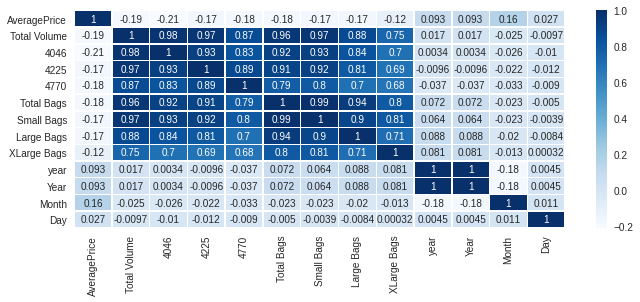

In [ ]:
plt.figure(figsize = (11,4))
sns.heatmap(df.corr(method='pearson'), cmap='Blues',  linewidth=0.5, annot=True);

**4 - DATA PREPARATION:**

Conforme sua documentação (disponibilizada em https://scikit-learn.org/stable/modules/tree.html), a biblioteca scikit-learn usa uma versão otimizada do algoritmo CART (Classification and Regression Trees), que suporta atributos target numéricos (problemas de regressão) mas, no entanto, a implementação do scikit-learn não oferece suporte a variáveis categóricas por enquanto.

Por isso, na sequência iremos lidar com aos atributos "type" e "region".

In [ ]:
len(df['region'].unique())

54

Como tranformar uma variável categórica com 54 possíveis valores em variáveis numéricas (sem umaordem arbitrária) aumentaria demais o número de atributos e dimensionalidade do problema, optou-se por retirar o atributo "Region" do dataset.

In [ ]:
df.drop('region', axis=1, inplace=True)

verificando a correlação dos atributos com o atributo TotalBags

In [ ]:
df.corr()['Total Bags'].sort_values(ascending = False)

Total Bags      1.000000
Small Bags      0.994335
Total Volume    0.963047
Large Bags      0.943009
4046            0.920057
4225            0.905787
XLarge Bags     0.804233
4770            0.792314
Year            0.071552
year            0.071552
Day            -0.004988
Month          -0.022724
AveragePrice   -0.177088
Name: Total Bags, dtype: float64

Como a correlação entre os atributos Small Bags, Large Bags e Total Bags é muito próxima de 1, os atributos de tamanhos pequeno e grande de sacolas serão removidos, deixando somente o atributo de sacolas totais vendidas (Total Bags) e de sacolas muito grande vendidas (XLarge Bags):

In [ ]:
df.drop(labels = ['Small Bags','Large Bags'],axis = 1, inplace = True)

Efetuando uma mudança de tipo de escala do atributo "type" de categórico/nominal para quantitativo binário (0 para avocado convencional ou 1 para avocado orgânico):

In [ ]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dicts = {}

label.fit(df.type.drop_duplicates()) 
dicts['type'] = list(label.classes_)
df.type = label.transform(df.type) 

In [ ]:
df.sample(4)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,XLarge Bags,type,year,Year,Month,Day
9380,1.91,3098.29,15.18,948.71,0.00,2134.40,0.00,1,2015,2015,2,8
8967,1.15,591211.37,160917.18,362263.89,1136.97,66893.33,5046.73,0,2018,2018,1,21
10709,1.96,8067.82,20.58,1104.69,0.00,6942.55,0.00,1,2015,2015,7,19
4239,0.97,293340.02,162451.07,39328.87,267.67,91292.41,4425.00,0,2016,2016,6,19


Verificando os quartir para possibilitar a identificação de possíveis outliers (que, dependendo do algortimo que será implementado, é necessário tratar), através do cálculos dos quartis de cada atributo e dos seus mínimos e máximos:

Quartis 1 (25%) e 3 (75%) e distância interquartis :

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print('Q1:\n\n',Q1,'\n\nQ3:\n\n', Q3,'\n\nIQR:\n\n',IQR)

Q1:

 AveragePrice        1.10
Total Volume    10838.58
4046              854.07
4225             3008.78
4770                0.00
Total Bags       5088.64
XLarge Bags         0.00
type                0.00
year             2015.00
Year             2015.00
Month               3.00
Day                 8.00
Name: 0.25, dtype: float64 

Q3:

 AveragePrice         1.66
Total Volume    432962.29
4046            111020.20
4225            150206.86
4770              6243.42
Total Bags      110783.37
XLarge Bags        132.50
type                 1.00
year              2017.00
Year              2017.00
Month                9.00
Day                 23.00
Name: 0.75, dtype: float64 

IQR:

 AveragePrice         0.56
Total Volume    422123.71
4046            110166.13
4225            147198.08
4770              6243.42
Total Bags      105694.73
XLarge Bags        132.50
type                 1.00
year                 2.00
Year                 2.00
Month                6.00
Day                 15.00

Mínimos de cada atributo (Lower Whisker):

In [ ]:
Upper_Whisker = Q3 + 1.5 * IQR
Lower_Whisker = Q1 - 1.5 * IQR
print('UPPER WHISKER:\n',Upper_Whisker,'\n\n','LOWER WHISKER:\n', Lower_Whisker)

UPPER WHISKER:
 AveragePrice          2.500
Total Volume    1066147.855
4046             276269.395
4225             371003.980
4770              15608.550
Total Bags       269325.465
XLarge Bags         331.250
type                  2.500
year               2020.000
Year               2020.000
Month                18.000
Day                  45.500
dtype: float64 

 LOWER WHISKER:
 AveragePrice         0.260
Total Volume   -622346.985
4046           -164395.125
4225           -217788.340
4770             -9365.130
Total Bags     -153453.455
XLarge Bags       -198.750
type                -1.500
year              2012.000
Year              2012.000
Month               -6.000
Day                -14.500
dtype: float64


Instâncias com possíveis outliers em alguns dos atributos (principais atributos numéricos):

In [ ]:
df[['AveragePrice', 'Total Volume', '4046', '4225', '4770']].loc[

(df['AveragePrice'] < 0.260) |
(df['Total Volume'] < -622346.985) |
(df['4046'] < -164395.125) |
(df['4225'] < -217788.340) |
(df['4770'] < -9365.130) |

(df['Total Volume'] > 1066147.855) |
(df['4046'] > 276269.395) |
(df['4225'] > 371003.980) |
(df['4770'] > 15608.550)]

,AveragePrice,Total Volume,4046,4225,4770
52,0.99,386100.49,292097.36,27350.92,297.90
54,0.96,417772.47,324932.28,31019.08,275.80
55,1.07,357636.82,283024.01,23740.85,181.92
60,0.99,419088.74,290457.50,62980.07,252.79
66,0.93,516432.60,346118.51,82762.72,1349.41
...,...,...,...,...,...
18220,1.53,1384683.41,117922.52,287724.61,1703.52
18221,1.61,1336979.09,118616.17,280080.34,1270.61
18222,1.63,1283987.65,108705.28,259172.13,1490.02
18223,1.59,1476651.08,145680.62,323669.83,1580.01


O dataset não apresenta valores faltantes, assim como não parece apresentar valores com ruído ou inconsistentes, apenas outliers. Outliers são valores incomuns mas que podem ser legítimos/reais, ou ainda inesperados num contexto local em que ocorrem mas que no contexto global poderiam ser valores esperados.  Ainda assim, normalmente distorcem o treino do modelo e causam modelos com maiores erros associados (modelos não costumam prever casos extremos), e por isso usualmente outliers são tratados ou retirados. O quanto influenciam na qualidade do modelo depende de que algoritmo se utiliza, bem como se se trata de um método de classificação, regressão etc. Neste trabalho os outliers serão tratados/eliminados se e quando necessário, visto que nem todos algoritmos são sensíveis a eles.


**5 - MODELING**

*5.1 - RANDOM FOREST:*

Random Forest é um algoritmo de ensemble learning. Este tipo de algorito utilizaa uma combinação de vários modelos base instáveis (a fim de promover variabilidade) de maneira homogênea (todos os modelos base são induzidos pelo mesmo algoritmo) ou heterogênea (os modelos base são induzidos por diferentes algoritmos) para, entre outras coisas, diminuir a variância.

Random Forest, do pornto de vista de classificação, é um algoritmo cujos modelos ocorrem em paralelo (também há algoritmos de ensemble learning cujos modelos ocorrem de maneira sequencial, como é o caso do Adaboost, por exemplo).

Algoritmos paralelos como o Bagging ou o Random Forest são aqueles cujos modelos podem ser processados em paralelo, utilizando o conceito de processamento em paralelo, e obtando rasultados de maneira mais rápida. Por outro lado, altorimos sequenciais como o Adaboost são aqueles cujos modelos são processados em série, ou seja, o modelo de número n apenas é processado quando o modelo n-1 já finalizou. Além disso, o modelo n é induzido pelo modelo n-1 quando se trata do conjunto de instâncias que o modelo n irá usar para treinar, isso porque as instâncias que foram incorretamente previstas/classificadas pelo modelo n-1 receberão um peso maior, e isso aumenta sua chance/frequência/probabilidade de aparecer no conjunto de instâncias que o modelo n irá utilizar para treinar.

Por um lado, Árvores de Decisão são modelos de fácil utilização e que não necessitam de pré-processamento dos dados. Por outro, classificação por Árvores de Decisão é um método muito suscetível a overfitting - principalmente quando não se controla adequadamente seus parâmetros de pruning -, e uma forma de melhorar isto é utilizando o método de Florestas Aleatórias, onde é possível criar várias árvores separadas (usando divisões diferentes do conjunto de dados) e dar como resposta da previsão a média das respostas de todas as árvores.

Ainda,  os atributos preditivos que são candidatos para servirem como divisores num nó são definidos de forma aleatória (escolhendo-se pra uma divisão o que apresentar melhor resultado - menos impureza por índice de Gini ou Entropia, por exemplo), o que garante que as árvores não tenham correlação entre si e o resultado seja mais preciso.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# numpy para converter os dados para arrays
Y = np.array(df['type'].values)
X = np.array(df.drop('type', axis = 1).values)

# Salvando a lista de features para "backup"
feature_list = list(df.columns)

Definindo um split dos dados de treino e teste, onde 30% serão guardados para apenas serem vistos e utilizados pelo modelo no momento de avaliação das métricas de desempenho do mesmo:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=101)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Features Shape: (5474, 11)
Training Labels Shape: (5474,)
Testing Features Shape: (12775, 11)
Testing Labels Shape: (12775,)


In [ ]:
X_train

array([[1.4300000e+00, 3.8061268e+05, 7.9261700e+03, ..., 2.0170000e+03,
        3.0000000e+00, 1.9000000e+01],
       [1.7000000e+00, 1.0629430e+04, 3.5435000e+02, ..., 2.0160000e+03,
        1.1000000e+01, 2.0000000e+01],
       [1.3300000e+00, 1.0860070e+04, 5.9211200e+03, ..., 2.0150000e+03,
        1.2000000e+01, 2.7000000e+01],
       ...,
       [1.6000000e+00, 2.4825500e+04, 6.5164000e+03, ..., 2.0180000e+03,
        3.0000000e+00, 2.5000000e+01],
       [1.3600000e+00, 7.8015200e+03, 1.8318000e+02, ..., 2.0180000e+03,
        2.0000000e+00, 1.1000000e+01],
       [1.8000000e+00, 2.1099000e+03, 2.6800000e+00, ..., 2.0160000e+03,
        7.0000000e+00, 2.4000000e+01]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# deve-se passar o número de modelos/estimadores/árvores como hiper-parâmetro do modelo ensemble de Floresta Aleatória
RF_model = RandomForestClassifier(max_depth=10, min_samples_split=0.1, min_samples_leaf=0.2, max_features='sqrt',
                                  bootstrap=True, oob_score=True, criterion='entropy', n_estimators=100) 

HIPERPARÂMETROS:

- max_depth: máxima profundidade (usou-se 10 - se muito elevado, causa overfitting)

- min_samples_split: porcentagem mínima de instâncias em relação ao número total que é necessário para realizar um split em um nó interno (usou-se 0.1 -  se muito elevado, causa underfitting, se muito baixo, causa overfitting)

- min_samples_leaf:  porcentagem mínima de instâncias em relação ao número total por folha (usou-se 0.2 - se muito elevado, causa underfitting, se muito baixo, causa overfitting)

- max_features: número de atributos que serão aleatoriamento sorteados para verificar qual faz melhor o split (usou-se "sqrt", que significa que serão escolhidos sqrt(X) antributos, onde X é o número de atributos do dataframe

- bootstrap: amostragem do tipo bootstrap (usou-se "True")

- oob_score: métricas serão testadas no conjunto de dados out-of-bag (usou-se "True")

- criterion: critério de avaliação da impureza (usou-se Entropia, tmabém poderia ser índice de Gini, por exemplo)

- n_estimators: número de árvores/modelos construídos (usou-se 2, 10, 25,50, 100, 300, 1000 e 2000)

O ideal seria tunar cada um dos hiperparâmetros separadamente e avaliar o melhor valor para cada um para este dataset, porém, a fim de utilizar o tempo disponível para avaliar outros algoritmos, no presente trabalho isto não será realizado.


In [ ]:
RF_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.2, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

*5.2 - Utilizando de outros algoritmos: Decision Tree Classifier (com critério de entropia), Regressão logística e AdaBoost Classifier:*

In [ ]:
from sklearn.model_selection import cross_validate,train_test_split, cross_val_score,KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
DT = DecisionTreeClassifier(criterion = 'entropy')
print(DT)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [ ]:
LG = LogisticRegression(random_state=0)
print(LG)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
ADA = AdaBoostClassifier()
print(ADA)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


Adaboost é um algoritmo de ensemble learning  assim como o Random Forest, porém, ele não funciona apenas com Árvores de Decisão e ocorre de maneira sequencial.

Para estes três modelos definidos acima optou-se por não tunar seus hiperparâmetros.

**6 - EVALUATION**

*6.1 - AVALIAÇÃO RANDOM FOREST:*

In [ ]:
RF_pred = RF_model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

In [ ]:
#print(classification_report(Y_test, RF_pred))
#print('\n')
print(confusion_matrix(Y_test, RF_pred))

[[6314   82]
 [1018 5361]]


Esta matriz é a base para o cálculo de todas as outras métricas de avaliação como accuracy, f1-score, entre outras.

*CROSS-VALIDATION:*

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
# 10-FOLD Cross Validation (10 divisões/modelos)
scoring = ['accuracy', 'precision', 'recall', 'f1']
RF_CV = cross_validate(RF_model, X_train, Y_train, cv=10,  scoring=scoring)

In [ ]:
for k, v in RF_CV.items():
    print (k, v)
    print('\n')

fit_time [0.3187561  0.30428481 0.30647469 0.29688716 0.32667994 0.30281258
 0.30201411 0.30298734 0.29848289 0.30056596]


score_time [0.01181626 0.01178932 0.01194811 0.01180077 0.01187611 0.01181984
 0.01152015 0.01170945 0.01162314 0.01186371]


test_accuracy [0.9270073  0.93065693 0.91970803 0.8959854  0.92870201 0.91224863
 0.91590494 0.92321755 0.91042048 0.91590494]


test_precision [0.9916318  0.9958159  0.99148936 0.96982759 0.97188755 0.96311475
 0.99137931 0.98333333 0.99559471 0.975     ]


test_recall [0.86181818 0.86545455 0.84727273 0.81818182 0.88321168 0.85766423
 0.83941606 0.86131387 0.82481752 0.8540146 ]


test_f1 [0.92217899 0.92607004 0.91372549 0.88757396 0.92543021 0.90733591
 0.90909091 0.91828794 0.90219561 0.91050584]




A taxa de acerto média (accuracy) pode não ser uma boa medida para datasets desbalanceados, o que não é o caso neste datase por isso avalia-se também outras métricas, como o F1-Score, por exemplo, entre outras.

A média de tais métricas e o respectivo intervalo de confiança a 95% (equivalente a +/- 2 desvios padrão) da estimativa são:

In [ ]:
print('taxa de acerto média: %0.4f (+/- %0.4f)' % (RF_CV['test_accuracy'].mean(), RF_CV['test_accuracy'].std() * 2))
print('\n')
print('precisão média: %0.4f (+/- %0.4f)' % (RF_CV['test_precision'].mean(), RF_CV['test_precision'].std() * 2))
print('\n')
print('recall médio: %0.4f (+/- %0.4f)' % (RF_CV['test_recall'].mean(), RF_CV['test_recall'].std() * 2))
print('\n')
print('F1-Score médio: %0.4f (+/- %0.4f)' % (RF_CV['test_f1'].mean(), RF_CV['test_f1'].std() * 2))

taxa de acerto média: 0.9180 (+/- 0.0197)


precisão média: 0.9829 (+/- 0.0228)


recall médio: 0.8513 (+/- 0.0371)


F1-Score médio: 0.9122 (+/- 0.0224)


*PARA OS HIPERPARÂMETROS MODIFICADOS COMO JÁ MENCIONADO ACIMA:*

- PRA 2 ÁRVORES:

taxa de acerto média: 0.8913 (+/- 0.0297)

precisão média: 0.9160 (+/- 0.0813)

recall médio: 0.8659 (+/- 0.0647)

F1-Score médio: 0.8889 (+/- 0.0263)

- PRA 10 ÁRVORES:

taxa de acerto média: 0.9105 (+/- 0.0258)

precisão média: 0.9728 (+/- 0.0198)

recall médio: 0.8451 (+/- 0.0454)

F1-Score médio: 0.9043 (+/- 0.0293)

- PRA 25 ÁRVORES:

taxa de acerto média: 0.9154 (+/- 0.0212)

precisão média: 0.9758 (+/- 0.0172)

recall médio: 0.8524 (+/- 0.0372)

F1-Score médio: 0.9099 (+/- 0.0238)

- PRA 50 ÁRVORES:

taxa de acerto média: 0.9129 (+/- 0.0183)

precisão média: 0.9765 (+/- 0.0218)

recall médio: 0.8466 (+/- 0.0269)

F1-Score médio: 0.9069 (+/- 0.0201)

- PRA 100 ÁRVORES:

taxa de acerto média: 0.9152 (+/- 0.0178)

precisão média: 0.9779 (+/- 0.0258)

recall médio: 0.8502 (+/- 0.0271)

F1-Score médio: 0.9095 (+/- 0.0195)

- PRA 300 ÁRVORES:

taxa de acerto média: 0.9147 (+/- 0.0218)

precisão média: 0.9774 (+/- 0.0250)

recall médio: 0.8495 (+/- 0.0314)

F1-Score médio: 0.9089 (+/- 0.0240)

- PRA 1000 ÁRVORES:

taxa de acerto média: 0.9136 (+/- 0.0194)

precisão média: 0.9758 (+/- 0.0238)

recall médio: 0.8488 (+/- 0.0278)

F1-Score médio: 0.9078 (+/- 0.0213)

- PRA 2000 ÁRVORES:

taxa de acerto média: 0.9149 (+/- 0.0224)

precisão média: 0.9786 (+/- 0.0247)

recall médio: 0.8488 (+/- 0.0304)

F1-Score médio: 0.9090 (+/- 0.0245)


*PARA OS HIPERPARÂMETROS COM SEUS VALORES PADRÃO:*

- PRA 50 ÁRVORES:

taxa de acerto média: 0.9903 (+/- 0.0067)

precisão média: 0.9949 (+/- 0.0113)

recall médio: 0.9858 (+/- 0.0100)

F1-Score médio: 0.9903 (+/- 0.0067)

- PRA 100 ÁRVORES:

taxa de acerto média: 0.9900 (+/- 0.0080)

precisão média: 0.9942 (+/- 0.0121)

recall médio: 0.9858 (+/- 0.0171)

F1-Score médio: 0.9899 (+/- 0.0081)

- PRA 300 ÁRVORES:

taxa de acerto média: 0.9907 (+/- 0.0068)

precisão média: 0.9952 (+/- 0.0086)

recall médio: 0.9862 (+/- 0.0129)

F1-Score médio: 0.9907 (+/- 0.0069)

Dado que as métricas de desempenho do modelo pouco variaram com o aumento (mesmo que bastante acentuado) do número de árvores utilizadas, há espaço para desconfiança, algum fator nos dados pode estar causando uma falsa boa impressão. Entretanto, os autores deste trabalho não foram capazes de determinar qual o problema e, logo, qual seria a possível solução.

Esse resultado observou-se inclusive quando são utilizados os valores padrão dos hiperparâmetros, sendo que nestes casos o desempenho do modelo foi ainda superior a quando utilizou-se valores teoricamente mais adequados. O que mostra mais uma incoerência do modelo.

Caso os resultados estivessem corretos, poderia-se optar por um baixo número de árvores, como 25, por exemplo, que já se teria um ótimo resultado e um custo computacional mais baixo do que se fosse se utilizar 100, 300 ou mais árvores.

In [ ]:
print('O número de instâncias com avocados orgânicos é %0.0f, já o número de instâncias com avocados convencionais é %0.0f'
        % (len(df[df['type']==1]), len(df[df['type']==0])))

O número de instâncias com avocados orgânicos é 9123, já o número de instâncias com avocados convencionais é 9126


Ou seja, o dataset é realmente bastante balanceado, o que justifica em parte e similaridade entre as métricas acurácia e f1-score. 

*6.2 - AVALIAÇÃO Decision Tree Classifier (com critério de entropia), Regressão logística e AdaBoost Classifier:*

Criando uma função para treinar K modelos de cada algoritmo e avaliá-los com o K-fold Cross Validation para k=10:

In [ ]:
def run_kfold(clf):
  kf = KFold(n_splits=10) # número de folds do Kfold
  outcomes = [] # lista dos resultados das métricas das acurácias dos modelos
  fold = 0 # fold inicial, vai ciclar com os outros folds

  for train_index, test_index in kf.split(X):
      fold += 1
      Xtrain, Xtest = X[train_index], X[test_index]
      ytrain, ytest = Y[train_index], Y[test_index]
      clf.fit(Xtrain, ytrain) # treinando o modelo do fold 
      predictions = clf.predict(Xtest)
      accuracy = accuracy_score(ytest, predictions)
      outcomes.append(accuracy) # agregando o resultado da acurácia do fold na lista

  mean_outcome = np.mean(outcomes) # média das acurácias dos folds do modelo
  max_outcome = np.max(outcomes) # acurácia máxima dos folds do modelo
  min_outcome = np.min(outcomes) # acurácia mínima dos folds do modelo
  print("Acurácia Média: {0}\n Acurácia Máxima: {1}\n Acurácia Mínima: {2}".format(mean_outcome,max_outcome,min_outcome)) 
  return None

In [ ]:
classifiers = [DT, ADA, LG]
for classifier in classifiers:
    print('\n\nClassificador:', classifier)
    run_kfold(classifier)



Classificador: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Acurácia Média: 0.924762947608748
 Acurácia Máxima: 0.9731506849315068
 Acurácia Mínima: 0.776986301369863


Classificador: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Acurácia Média: 0.9262369021869743
 Acurácia Máxima: 0.9747945205479452
 Acurácia Mínima: 0.8234649122807017


Classificador: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   mul

Uma árvore consiste em um grande número de nós e pode exigir uma quantidade significativa de esforço mental para compreender todas as divisões que levam a uma determinada previsão. Em contraste, um modelo de regressão logística é simplesmente uma lista de coeficientes. Ou seja, do ponto de vista de interpretabilidade, na maioria das vezes a regressão logística vai se sair melhor. O Adaboost vai depender do algoritmo base, mas no geral, se se utiliza de árvores de decisão, por exemplo, sua interpretabilidade é precária.

Já do ponto de vista de custo combitacional não há dúvidas de que o Adaboost tende a ser o mais custoso, dado sua natureza de ensemble learning sequencial. Comparando a regressão logística com a árvore de decisão pode variar bastante de caso para caso, porem, a tendêcias é que os modelos desenvolvidos com o algoritmo de regressão logística possuam menor custo computacional.

Desta forma, pode-se dizer que, para este dataset, o algoritmo de regressão logística é uma ótima escolha, sendo suficiente para garantir um bom resultado (na média próximo a 90%) com baixo custo computacional e boa interpretabilidade.

*6.3 - ROC-AUC ENTRE ALGORITMOS:*

Uma forma de avaliar e comparar modelos de classificação é com a área sob a curva ROC (Receiver Operating Characteristics), ou AUC (Area Under Curve), de cada modelo, que combina as a variação das métricas recall e precisão (1-especificidade).

A curva ROC é gerada traçando todos os valores de corte possíveis, que são as probabilidades atribuídas a cada observação. Selecionar um valor de corte diferente irá alterar a sensibilidade e especificidade da ferramenta de predição, portanto, cada probabilidade de corte pode ser plotada no espaço do gráfico usando a sensibilidade associada e especificidade 1 como as coordenadas. O ponto mais próximo do canto superior esquerdo fornece o maior equilíbrio entre as métricas de precisão.

A AUC varia entre 0 e 1, sendo 1 para um algoritmo perfeito, 0,5 para o modelo que não tem capacidade de discriminação para distinguir entre classe positiva e classe negativa (seria o mesmo que jogar uma moeda não viciada), e aproximadamente 0 quando o modelo está na verdade trocando as classes, ou seja, o modelo está prevendo uma classe negativa como uma classe positiva e vice-versa.


In [ ]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

Curva ROC e respectiva AUC para o modelo de Random Forest:

In [ ]:
#run_kfold(classifier)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, RF_pred, pos_label=1)

random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(Y_test, RF_pred)

print(auc_score1)

0.913796672575478


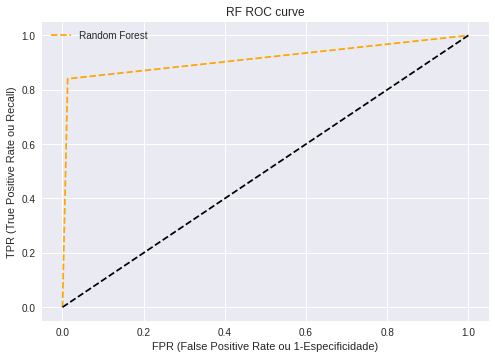

In [ ]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('RF ROC curve')
# x label
plt.xlabel('FPR (False Positive Rate ou 1-Especificidade)')
# y label
plt.ylabel('TPR (True Positive Rate ou Recall)')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

O modelo de Random Forest fornecer uma AUC de aproximadamento 0.9, o que significa que cerca de 90% dos objetos são corretamente classificados. Este resultado é muito bom.

Criando uma função para aplicar a curva ROC a cada um dos modelos do Cross Validation de cada um dos outros algoritmos utilizados:

In [ ]:
from sklearn.metrics import auc
def StratifKFoldROC (model, data, splits):

  cv = StratifiedKFold(n_splits = splits)
  classifier = model
  y = np.array(data['type'].values)
  X = np.array(data.drop('type', axis = 1).values)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  
  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.4, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance (AUC=0.5)', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)


  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Curva ROC para o modelo {}".format(type(model).__name__))
  ax.legend(loc="lower right")
 
  plt.show()

Plotando a curva ROC para o modelo de Regressão Logítica (para todos os  8 modelos criados no cross-validaton e para a média):


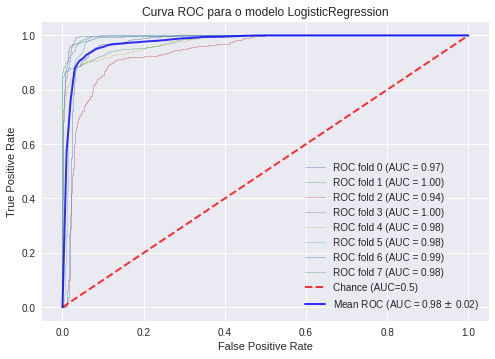

In [ ]:
StratifKFoldROC(LG, df, 8)

Plotando a curva ROC para o modelo Adaboost (para todos os  8 modelos criados no cross-validaton e para a média):


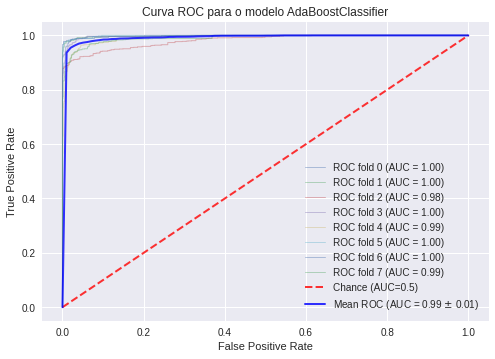

In [ ]:
StratifKFoldROC(ADA, df, 8)

Plotando a curva ROC para o modelo de Árvore de Decisão (para todos os  8 modelos criados no cross-validaton e para a média):


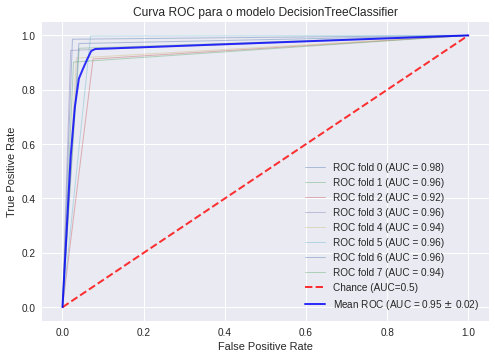

In [ ]:
StratifKFoldROC(DT, df, 8)

O valores da AUC para os três algoritmos são bastante elevados, isso signifca que se fossem valores reais todos os três modelos teriam ótimos resultados, porém, provavelmente se passa algum erro, que não foi identificado.

**7 - CONCLUSÃO**

Dado o critério de sucesso estabelecido na seção 2.5, conclui-se que o resultado foi satisfatório. Isso porque todos os modelos utilizados na média forneceram um resultado superior a 90%. 

Verificou-se ainda que as diferenças de performance entre os quatro modelos testados são muito baixas, provavelmente em função das características do dataset, que não conta com dados faltantes nem ruído e cujos atributos preditivos com forte correlação foram eliminados (o que, caso não tivesse sido feito,  afetaria principalmente o modelo de regressão logística).

Os outliers, por sua vez, não foram eliminados, o que esperava-se que poderia afetar fortemente o modelo de regressão logística - o que não foi observado -, mas não os demais algoritmos utilizados. 

O único modelo que fornecer um resultado consideravelmente superior os demais foi o do Random Forest, porém, como já explicado anteriormente, ele parece possuir algumas incoerências. Desta forma, como discutido na seção de avaliação, o modelo que apresentou melhor relação de custo (computacional)/benefício (elevada performance média) foi o de regressão logística.

Pode-se deixar como sugestão para trabalhos futuros com o mesmo objetivo que o presente, ou seja, ainda sem falar em predição os seguintes pontos:

- Avaliar possíveis erros no modelo Random Forest;

- Verificar a veracidade das curvas ROC e respectivas AUCs;

- Remover outliers e voltar a treinar e avaliar o modelo de Regressão Logística.
